# light on/off classification model

```
- 센서 데이터.csv -
sensor, datetime, label
0, 2020-07-01 08:28:37, 0
35, 2020-07-01 08:38:37, 1
40, 2020-07-01 08:48:37, 1
0, 2020-07-01 08:58:37, 0
0, 2020-07-01 09:08:37, 0
0, 2020-07-01 09:18:37, 0

- 데이터 내용 -
column1(sensor) - 365일 동안 10분 간격으로 조도센서(값:0~100)
column2(datetime) - datetime
column3(label) - light on: 1, light off:0
```

## 1. setup

In [1]:
from datetime import datetime as dt
import cv2, csv, os, glob, locale
from pprint import pprint

# import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.math import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
import plotly.express as px


# 텐서보드 활성화
%load_ext tensorboard

2021-07-29 09:57:30.995026: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# path
path = '/home/z/PycharmProjects/test/label/'
filepath = 'labeling_NW0511.csv'
df = pd.read_csv(path + filepath)
df = df[['device_field03', 'illuminance_onoff', 'device_data_reg_dtm']]
light_data = df['device_field03']
label_data = df['illuminance_onoff']
time_data = df['device_data_reg_dtm']
on_value = 1
off_value = 0

print(light_data.shape)
print(label_data.shape)

(48984,)
(48984,)


## 2. filter data

In [3]:
# 9 to 0
flag = 0
for row, label in label_data.iteritems():
    if label == 9 and flag == 0:
        df.at[row, 'illuminance_onoff'] = off_value
    elif label == 9 and flag == 1:
        df.at[row, 'illuminance_onoff'] = on_value
    elif label == 1 and flag == 0:
        flag = 1
    elif label == 0 and flag == 1:
        flag = 0


In [4]:
# night time filter
cnt = 0
for (row, light), (i, label), (j, time) in zip(light_data.iteritems(), label_data.iteritems(), time_data.iteritems()):
    t = time[11:13]
    if light < 5: df.at[row, 'illuminance_onoff'] = off_value
    if 9 < int(t) < 18: df.at[row, 'illuminance_onoff'] = off_value

In [5]:
# threadhold filter
light = 0
threshold = 15
prev = 0
flag = 0
for row, now in light_data.iteritems():
    if now - prev > threshold and flag == 0:
        df.at[row, 'illuminance_onoff'] = on_value
        flag = 1
    elif prev - now > threshold and flag == 1:
        df.at[row-1, 'illuminance_onoff'] = on_value
        flag = 0
    # elif flag == 1 and -1 < prev - now < 1:
    #     df.at[row, 'illuminance_onoff'] = on_value
    # elif flag == 0:
    #     df.at[row, 'illuminance_onoff'] = off_value
    prev = now

In [ ]:
# plot
fig = px.line(df, x='device_data_reg_dtm', y=['device_field03', 'illuminance_onoff'])
fig.update_xaxes(rangeslider_visible=True)
# fig.show()

In [140]:
# Nomalize
mx = light_data.max()
norm_data = light_data / mx

print(norm_data.shape)
print(norm_data[:10])

(48984,)
0    0.345455
1    0.345455
2    0.345455
3    0.345455
4    0.345455
5    0.309091
6    0.309091
7    0.345455
8    0.345455
9    0.000000
Name: device_field03, dtype: float64


In [141]:
# Split
split_index = int(len(light_data)*0.9)
train_data, test_data = norm_data[:split_index], norm_data[split_index:]
train_label, test_label = label_data[:split_index], label_data[split_index:]

print(train_data.shape, test_data.shape)
print(train_label.shape, test_label.shape)

(44085,) (4899,)
(44085,) (4900,)


In [9]:
# label data start padding
label_data.loc[-1] = 0
label_data.index = label_data.index + 1
label_data = label_data.sort_index()
print(label_data)

0        0
1        1
2        0
3        0
4        0
        ..
48980    1
48981    1
48982    1
48983    1
48984    1
Name: illuminance_onoff, Length: 48985, dtype: int64


In [10]:
# def to_sequences(seq_size, obs):
#     x = []
#     y = []

#     for i in range(len(obs)-SEQUENCE_SIZE):
#         #print(i)
#         window = obs[i:(i+SEQUENCE_SIZE)]
#         after_window = obs[i+SEQUENCE_SIZE]
#         window = [[x] for x in window]
#         #print("{} - {}".format(window,after_window))
#         x.append(window)
#         y.append(after_window)
        
#     return np.array(x),np.array(y)
    
    
# SEQUENCE_SIZE = 10
# x_train,y_train = to_sequences(SEQUENCE_SIZE,spots_train)
# x_test,y_test = to_sequences(SEQUENCE_SIZE,spots_test)

# print("Shape of training set: {}".format(x_train.shape))
# print("Shape of test set: {}".format(x_test.shape))

In [138]:
# cnn data to rnn data
timesteps = 6
generator = k.preprocessing.sequence.TimeseriesGenerator(
	norm_data[:], label_data[:-1], length, sampling_rate=1, stride=1, 
    start_index=0, end_index=None, shuffle=False, 
	reverse=False, batch_size=20,)
	
print('Samples: ', len(generator))
for i in range(1):
	x, y = generator[i]
	print(x, '>>>', y)

Samples:  2449
[[0.34545455 0.34545455 0.34545455 0.34545455 0.34545455 0.30909091]
 [0.34545455 0.34545455 0.34545455 0.34545455 0.30909091 0.30909091]
 [0.34545455 0.34545455 0.34545455 0.30909091 0.30909091 0.34545455]
 [0.34545455 0.34545455 0.30909091 0.30909091 0.34545455 0.34545455]
 [0.34545455 0.30909091 0.30909091 0.34545455 0.34545455 0.        ]
 [0.30909091 0.30909091 0.34545455 0.34545455 0.         0.        ]
 [0.30909091 0.34545455 0.34545455 0.         0.         0.        ]
 [0.34545455 0.34545455 0.         0.         0.         0.        ]
 [0.34545455 0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.    

In [11]:
# # data start padding
# train_label.loc[-1] = 0
# train_label.index = train_label.index + 1
# train_label = train_label.sort_index()
# print(train_label)

# # label data start padding
# test_label.loc[-1] = 0
# test_label.index = test_label.index + 1
# test_label = test_label.sort_index()
# print(test_label)

In [12]:
# # cnn data to rnn data
# timesteps = 2
# p = -1
# train_generator = k.preprocessing.sequence.TimeseriesGenerator(
# 	train_data[:], train_label[:p], timesteps, sampling_rate=1, stride=1, 
#     start_index=0, end_index=None, shuffle=False, 
# 	reverse=False, batch_size=1,)
	
# test_generator = k.preprocessing.sequence.TimeseriesGenerator(
# 	test_data[:], test_label[:p], timesteps, sampling_rate=1, stride=1, 
#     start_index=0, end_index=None, shuffle=False, 
# 	reverse=False, batch_size=1,)
	
# print('Samples: ', len(train_generator))
# for i in range(100):
# 	x, y = train_generator[i]
# 	print(x, '>>>', y)

# print('Samples: ', len(test_generator))
# for i in range(100):
# 	x, y = test_generator[i]
# 	print(x, '>>>', y)

In [139]:
# model
input = k.Input(shape=(timesteps,1))

x = k.layers.Dense(10, activation="sigmoid")(input)

output = k.layers.Dense(1, activation="sigmoid")(x)

model = k.Model(input, output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# fit
log_path = "logs/" + dt.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = k.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1)
es = EarlyStopping(monitor="loss", patience=100, mode="min", verbose=1)

history = model.fit(generator, validation_split=0.2, steps_per_epoch=1, epochs=1000, verbose=0, callbacks=[es]) # callbacks=[es, tensorboard_callback])

# plot
pd.DataFrame(history.history).plot(figsize=(16,10), grid=1, xlabel="epoch", ylabel="accuracy")
plt.show()

Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 6, 1)]            0         
_________________________________________________________________
dense_51 (Dense)             (None, 6, 10)             20        
_________________________________________________________________
dense_52 (Dense)             (None, 6, 1)              11        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


2021-07-29 11:08:29.920691: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-29 11:08:29.920714: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-29 11:08:30.069553: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-07-29 11:08:30.076941: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found following types in the input: [<class 'tensorflow.python.keras.preprocessing.sequence.TimeseriesGenerator'>]

In [111]:
# # dataset
# series = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# # reshape to [10, 1]
# n_features = 1
# series = series.reshape((len(series), n_features))

# # generator
# n_input = 2
# generator = TimeseriesGenerator(series, series, length=n_input, batch_size=8)

# # model
# model = k.Sequential()
# model.add(k.layers.LSTM(100, activation='sigmoid', input_shape=(length, n_features)))
# model.add(k.layers.Dense(2))
# model.compile(optimizer='adam', loss='binary_crossentropy')

# # fit 
# history = model.fit_generator(generator, steps_per_epoch=1, epochs=100, verbose=0)

# # make a one step prediction out of sample
# x_input = np.array([9, 10]).reshape((1, n_input, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

# # plot
# pd.DataFrame(history.history).plot()
# plt.show()

In [112]:
# input = k.Input(shape=(length,1))

# x = k.layers.Conv1D(100, (), activation="sigmoid", dropout=0.1, recurrent_dropout=0.1)(input)

# output = k.layers.Dense(2)(x)

# model = k.Model(input, output)
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()

In [124]:
# input = k.Input(shape=(timesteps,1))

# x = k.layers.LSTM(1, activation="sigmoid", dropout=0.9, recurrent_dropout=0.9)(input)

# output = k.layers.Dense(1, activation="sigmoid")(x)

# model = k.Model(input, output)
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()

Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 6, 1)]            0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


2021-07-29 10:54:40.534668: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-29 10:54:40.534691: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-29 10:54:40.654773: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-07-29 10:54:40.656305: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed


Epoch 00818: early stopping


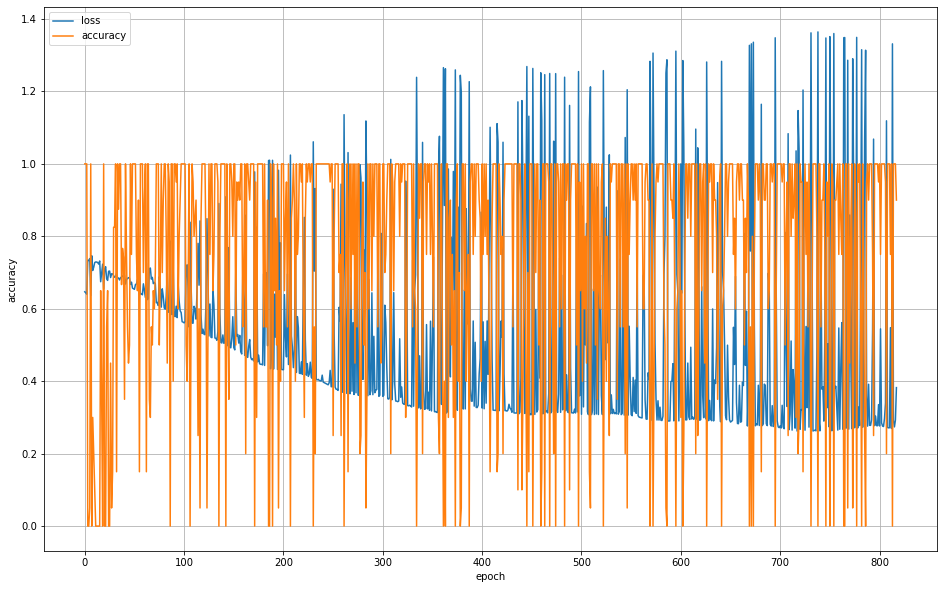

In [134]:
# log_path = "logs/" + dt.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = k.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1)
# es = EarlyStopping(monitor="loss", patience=100, mode="min", verbose=1)

# history = model.fit_generator(generator, steps_per_epoch=1, epochs=1000, verbose=0, callbacks=[es]) # callbacks=[es, tensorboard_callback])

# # plot
# pd.DataFrame(history.history).plot(figsize=(16,10), grid=1, xlabel="epoch", ylabel="accuracy")
# plt.show()

In [51]:
# plot

# # fig, (ax1, ax2) = plt.subplots(1, 2)
# # accuracy plot
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy') plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # loss plot
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_data,  test_label, verbose=2)

print('\nTest accuracy:', test_acc)

In [ ]:
# tensorboard @ localhost:6006
%tensorboard --logdir logs/ --host localhost --port 6006

In [ ]:
probability_model = k.Sequential([model, k.layers.Softmax()])
predictions = probability_model.predict(test_data)


0

In [ ]:
np.argmax(predictions[0])

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [ ]:
test_label[0]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [ ]:
########## 평가 ##########
model.evaluate(test_data, test_label)

1/1 [==============================] - 0s 221ms/step - loss: 0.0630 - accuracy: 0.9959


[0.06301040947437286, 0.9959149956703186]

In [ ]:
########## CM ##########
y5 = model.predict(test_data)
predicted = np.argmax(y5, axis=1)

draw_CM(test_label, predicted)

NameError: name 'draw_CM' is not defined

In [ ]:
########## ROC, AUC ##########
y5 = label_binarize(test_y, classes=classes)
x5 = label_binarize(predicted, classes=classes)

draw_ROC_AUC(x5, y5, category_names)